In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import torch
import wandb
from torch.utils.data import DataLoader
import shap

import matplotlib.pyplot as plt

from datasets import BrainFeaturesDataset, FEATURES_CORTICAL, FEATURES_VOLUME, FEATURES_VOLUME_EXTRA
from models import SimpleMLP

features_names = FEATURES_CORTICAL + FEATURES_VOLUME + FEATURES_VOLUME_EXTRA

In [3]:
device = 'cpu'
run_id = f'tjiagom/adni_phenotypes/2cxy59fk'
api = wandb.Api()
best_run = api.run(run_id)

model = SimpleMLP(dim_in=155, dropout_rate=best_run.config['dropout']).to(device)

restored_path = wandb.restore('simple_mlp.pt', replace=True, run_path=run_id)

model.load_state_dict(torch.load(restored_path.name, map_location=device))
model.eval()

SimpleMLP(
  (fc1): Linear(in_features=155, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (activation_h1): Tanh()
  (activation_h2): Tanh()
  (activation_final): Sigmoid()
  (dropout_layer): Dropout(p=0.8, inplace=False)
)

In [4]:
train_dataset = BrainFeaturesDataset('../data/adni_train_scaled_corrected.csv')
val_dataset = BrainFeaturesDataset('../data/adni_test_scaled_corrected.csv')

#dataset = BrainFeaturesDataset(dataset_location, has_target=False, keep_ids=True)
#loader = DataLoader(dataset, batch_size=200, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [5]:
e = shap.DeepExplainer(model, torch.tensor(train_dataset.X).to(device))
shap_values = e.shap_values(torch.tensor(val_dataset.X).to(device))

In [6]:
train_dataset.X.shape, val_dataset.X.shape

((662, 155), (74, 155))

In [7]:
# Just to check the outputs
model(torch.tensor(val_dataset.X).to(device))

tensor([[0.4471],
        [0.0054],
        [0.0091],
        [0.9572],
        [0.9914],
        [0.0052],
        [0.0056],
        [0.0081],
        [0.9922],
        [0.0139],
        [0.5885],
        [0.0615],
        [0.9889],
        [0.0139],
        [0.9145],
        [0.9934],
        [0.2124],
        [0.0528],
        [0.0073],
        [0.0397],
        [0.9768],
        [0.0034],
        [0.9860],
        [0.0082],
        [0.0056],
        [0.1637],
        [0.0336],
        [0.9873],
        [0.9948],
        [0.4432],
        [0.0040],
        [0.0265],
        [0.0101],
        [0.0499],
        [0.8801],
        [0.0092],
        [0.9951],
        [0.4951],
        [0.9883],
        [0.0243],
        [0.9955],
        [0.0381],
        [0.9939],
        [0.0033],
        [0.9973],
        [0.8866],
        [0.9913],
        [0.0139],
        [0.9959],
        [0.0093],
        [0.9965],
        [0.9957],
        [0.0371],
        [0.0123],
        [0.3593],
        [0

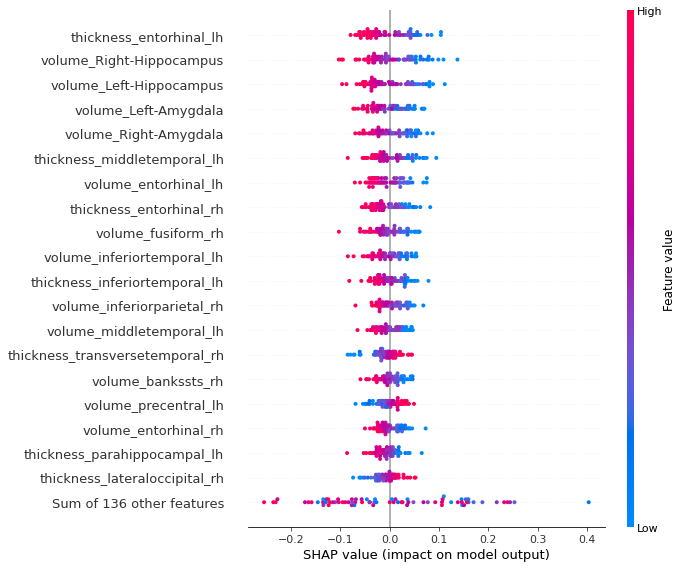

In [8]:
shap.plots.beeswarm(shap.Explanation(shap_values, data=val_dataset.X,feature_names=features_names), show=False, max_display=20)
plt.savefig('figs/shap_beeswarm.png', dpi=300, bbox_inches = 'tight')

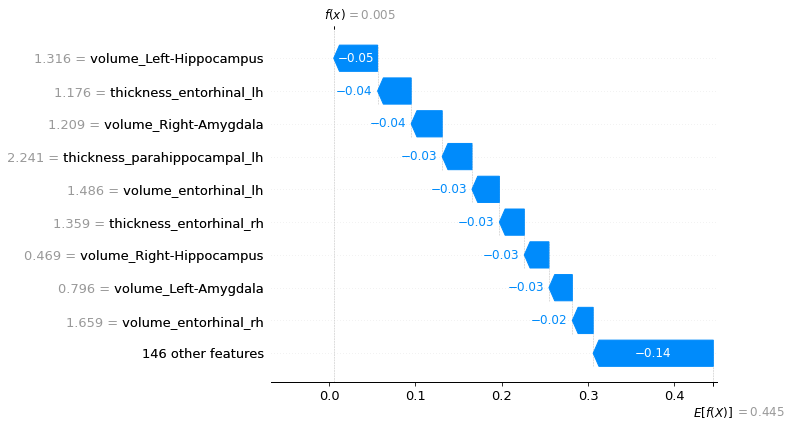

In [9]:
shap.plots.waterfall(shap.Explanation(shap_values, 
                                      base_values=e.expected_value[0], 
                                      data=val_dataset.X,
                                      feature_names=features_names)[1], show=False)
plt.savefig('figs/shap_waterfall_control.png', dpi=300, bbox_inches = 'tight')

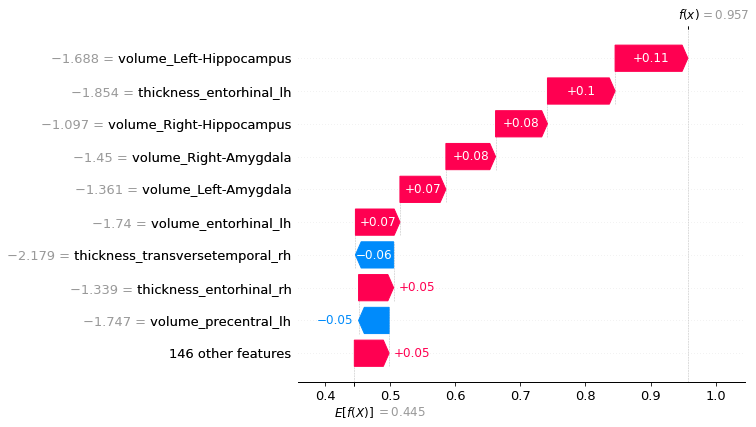

In [10]:
shap.plots.waterfall(shap.Explanation(shap_values, 
                                      base_values=e.expected_value[0], 
                                      data=val_dataset.X,
                                      feature_names=features_names)[3], show=False)
plt.savefig('figs/shap_waterfall_ad.png', dpi=300, bbox_inches = 'tight')

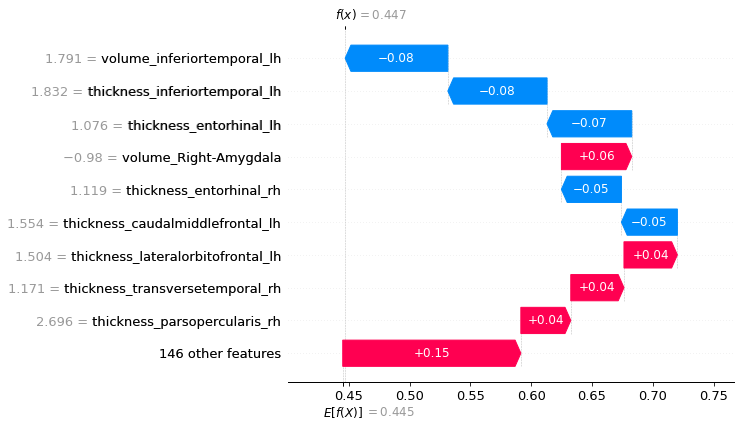

In [11]:
shap.plots.waterfall(shap.Explanation(shap_values, 
                                      base_values=e.expected_value[0], 
                                      data=val_dataset.X,
                                      feature_names=features_names)[0])

In [12]:
#var1, var2 = 'volume_inferiortemporal_lh', 'volume_Right-Amygdala'

#shap.dependence_plot(var1, shap_values, val_dataset.X, 
#                     interaction_index=var2, feature_names=features_names)